## Agroforestry RAG System

This notebook implements a Retrieval-Augmented Generation (RAG) system designed to answer questions about agroforestry, focusing on topics like carbon stocks, sequestration, and soil data. The system leverages a combination of techniques including:

1.  **Information Retrieval:** Identifying relevant articles from a collection of JSON documents based on the user's query.
2.  **Text Processing:** Chunking and reranking text excerpts from the retrieved articles to extract the most relevant information.
3.  **Language Model (LLM) Generation:** Using a large language model (LLM) to synthesize the extracted information and generate a coherent answer to the user's question.

The goal is to provide accurate and contextually grounded answers by retrieving information from a specific knowledge base (the provided JSON articles) rather than relying solely on the LLM's pre-existing training data. This approach helps to reduce the risk of the LLM "hallucinating" or generating incorrect information.

The notebook is structured into several sections:

*   **Set up and Installation:** Installs necessary libraries and sets up the environment.
*   **Utilities:** Defines helper functions for tasks like calculating cosine similarity, retrieving relevant articles, chunking text, embedding text, reranking text, and generating responses.
*   **Running the model:** Contains the main execution logic for the RAG system, including loading data, processing the query, retrieving and processing articles, and generating the final answer.
*   **Benchmarking:** (If applicable) Provides a section for evaluating the performance of the RAG system.

Each section includes code cells and markdown descriptions to explain the steps involved.

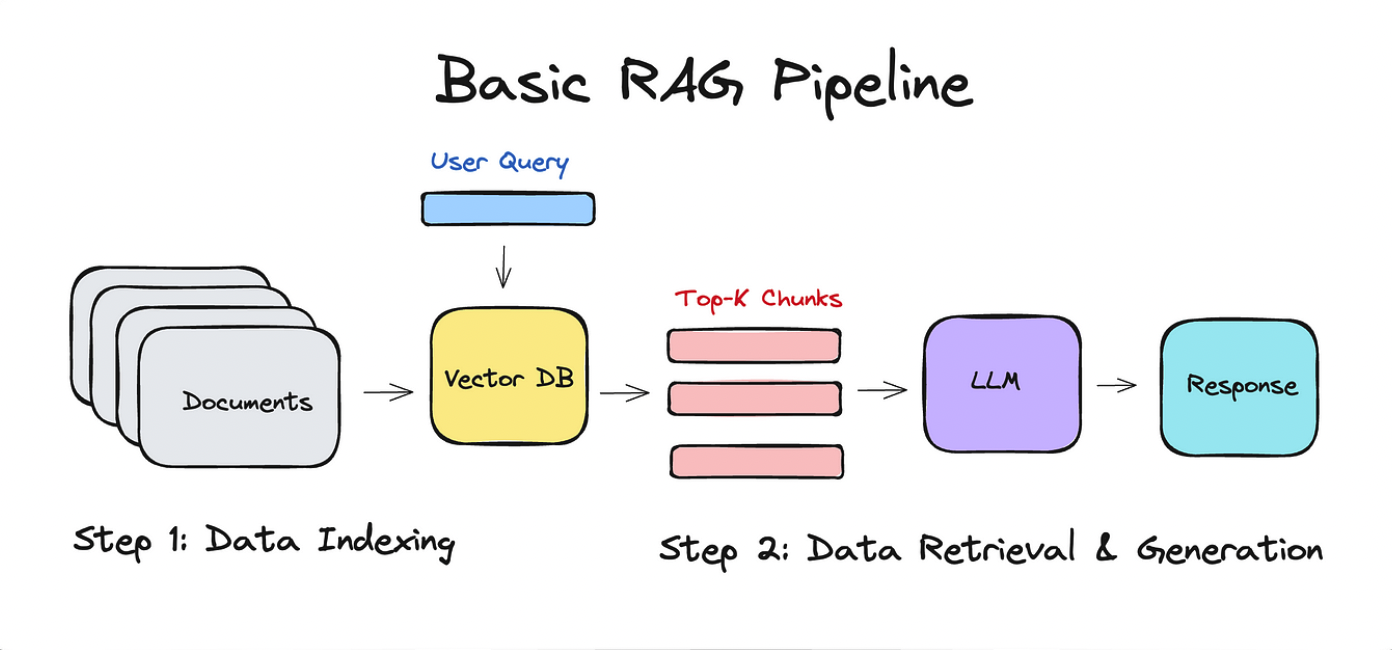

# **Set up and Installations**

In [ ]:
%pip install colab-xterm python-dotenv transformers groq ollama termcolor spacy nltk numpy langchain-community langchain-huggingface sentence-transformers transformers torch accelerate tqdm chromadb
%load_ext colabxterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 143.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.4/441.4 kB 51.6 MB/s 

In [ ]:
# Initialise variables:

llm_model_name = "mistral:7b"
test_question = "What is the aboveground_carbon of planting shaded agroforests in Plateau region?"

# Initiating Ollama server
The first step will be to initiate your own Ollama server. Ollama is way that you can run large languge models directly on your local computer! In our RAG pipeline, we will use Ollama to access LLM models to answer user questions.

**To initiate the Ollama server, please review and follow the following instructions.**
- First, click the run button in the next cell.

- After the code cell block runs and black terminal screen appears like so:

```
/content#
```
- Run the command "curl https://ollama.ai/install.sh | sh", the terminal should look like:


```
/content# curl https://ollama.ai/install.sh | sh
```
- After this command finishes running, the terminal will look something like:


```
/content# curl https://ollama.ai/install.sh | sh
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13281    0 13281    0     0  21107      0 --:--:-- --:--:-- --:--:-- 21080
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
WARNING: systemd is not running
WARNING: Unable to detect NVIDIA/AMD GPU. Install lspci or lshw to automatically detect and install GPU dependencies.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
/content#
```
- Next, in the new \content # line, run "ollama serve &":

```
/content# ollama serve &
```
- The output will be something like



```
/content# ollama serve &
[1] 5373
/content# Couldn't find '/root/.ollama/id_ed25519'. Generating new private key.
Your new public key is:

<<your key here, I removed mine for demonstration purposes>>

time=2025-07-08T19:37:00.523Z level=INFO source=routes.go:1235 msg="server config" env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_CONTEXT_LENGTH:4096 OLLAMA_DEBUG:INFO OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NEW_ENGINE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:0 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://* vscode-webview://* vscode-file://*] OLLAMA_SCHED_SPREAD:false ROCR_VISIBLE_DEVICES: http_proxy: https_proxy: no_proxy:]"
time=2025-07-08T19:37:00.524Z level=INFO source=images.go:476 msg="total blobs: 0"
time=2025-07-08T19:37:00.524Z level=INFO source=images.go:483 msg="total unused blobs removed: 0"
time=2025-07-08T19:37:00.524Z level=INFO source=routes.go:1288 msg="Listening on 127.0.0.1:11434 (version 0.9.6)"
time=2025-07-08T19:37:00.524Z level=INFO source=gpu.go:217 msg="looking for compatible GPUs"
time=2025-07-08T19:37:00.834Z level=INFO source=types.go:130 msg="inference compute" id=GPU-ac9be9db-8a01-bc25-ae4a-eba63223c2f3 library=cuda variant=v12 compute=7.5 driver=12.4 name="Tesla T4" total="14.7 GiB" available="14.6 GiB"
```

- Next, run "ollama pull llm_model_name". NOTE: Instead of llm_model_name, replace with your actual model name. For example if you're using deepseek-r1:1.5b, you would run "ollama pull deepseek-r1:1.5b"
- This time, the /content# prefix will not appear. However, just click the first blank line in the terminal and copy in the ollama pull command in the above line. The output should look something like this:

```
ollama pull deepseek-r1:1.5b
[GIN] 2025/07/08 - 19:37:29 | 200 |      74.151µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠼ time=2025-07-08T19:37:32.495Z level=INFO source=download.go:177 msg="downloading aabd4debf0c8 in 12 100 MB part(s)"
pulling manifest
pulling aabd4debf0c8: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 GB                         tpulling manifest
pulling aabd4debf0c8: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 GB                         
pulling manifest pulling aabd4debf0c8: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 GB                         
pulling manifest
pulling aabd4debf0c8: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 GB                         pulling manifest
pulling manifest
pulling aabd4debf0c8: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 GB                         pulling c5ad996bda6e: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  556 B                         
pulling 6e4c38e1172f: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ 1.1 KB                         
pulling f4d24e9138dd: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  148 B                         
pulling a85fe2a2e58e: 100% ▕██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  487 B                         
verifying sha256 digest
writing manifest
success
/content#
```
- **And you're done! :)**
- Note, we also included the commands in order as comments in the code block that you want to run, so you can easily copy and paste from there!









In [ ]:
%xterm
'''
First, run: curl https://ollama.ai/install.sh | sh

Then, run: ollama serve &

Lastly, run: ollama pull <<llm_model_name>>

NOTE: Instead of llm_model_name, replace with your actual model name. For example if you're using deepseek-r1:1.5b, you would run:
ollama pull deepseek-r1:1.5b
'''

Launching Xterm...

<IPython.core.display.Javascript object>

"\nFirst, run: curl https://ollama.ai/install.sh | sh\n\nThen, run: ollama serve &\n\nLastly, run: ollama pull <<llm_model_name>>\n\nNOTE: Instead of llm_model_name, replace with your actual model name. For example if you're using deepseek-r1:1.5b, you would run:\nollama pull deepseek-r1:1.5b\n"

In [ ]:
from dotenv import load_dotenv
from transformers import AutoTokenizer
load_dotenv()
import re
from groq import Groq
import json
import ollama
from pathlib import Path
from termcolor import colored
import spacy
import nltk
import numpy as np
from langchain_huggingface import HuggingFaceEmbeddings
import os
from sentence_transformers import SentenceTransformer
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.tokenize import sent_tokenize
from google.colab import userdata
from google.colab import drive
import random
import chromadb




In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#Google Drive and API Key Set Up


**Googl Drive Documents Set Up**

In our code, we're using some pre-recorded documents that we have set up in our Google Drive. In order to run the following code, you will need have these same documents.

- Please navigate to this Google Drive link https://drive.google.com/drive/folders/1NcZC_CvAuFIo-tL5VC-Mxwm1Ce4N_82v?usp=drive_link and click the "Download All" button located near the upper right corner of your screen. Don't worry if this takes a while to download, it's quite a large file (around 1 GB)!

- This will download as a ZIP file. Extract the ZIP file, and now you should have a folder called "**RAG Materials**"

- Now, upload the entire RAG Materials folder, into your "My Drive" folder on Google Drive, and you're done!

- NOTE: Make sure to only upload it to your My Drive folder and not any other folder within the My Drive folder.



To run the following code, we need to grant access Google Colab access to your Google Drive, since we will be using the documents from RAG Materials that you just uploaded.

- Let's connect your Google Drive. Once you click run for the following code cell, it will ask if you want to allow Google Colab to access Google Drive, click "Connect to Google Drive".
- Then, it will prompt you to chose a Google account to connect with. Choose the account that you just uploaded the RAG Materials folder to
- Next you will be prompted to agree to connect your drive. Click Continue for all the steps.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**API Key Set Up**

Additionally, we also need to set up an API key from Hugging Face, which will allow us to get access to ready-to-use machine learning models. We will be using a few of these models in our RAG pipeline!

- Please follow this YouTube tutorial to first sign up for a free Hugging Face account: https://www.youtube.com/watch?v=mRFNm89F1tk

- After you have set up your account, please follow this YouTube tutorial to set up an API key to use in Google Colab: https://www.youtube.com/watch?v=pB-j1VgP2s8

- NOTE: The video uses HF_demo for their secret name. For our code, you would want to name your secret **HUGGINGFACE_HUB_TOKEN**

In [ ]:
hugging_face_key = userdata.get("HUGGINGFACE_HUB_TOKEN")

## Utilities

This section contains various Python functions that are used throughout the RAG system. These functions handle tasks such as:

*   Calculating the similarity between text embeddings (`cosine`).
*   Finding the most relevant articles based on keywords and embeddings (`get_relevant_excerpts`).
*   Splitting article text into smaller, manageable chunks (sentences or groups of sentences) while respecting token limits (`chunk_document`).
*   Generating numerical representations (embeddings) of text using a pre-trained model (`embed_texts`).
*   Ranking text chunks based on their relevance to the user's query (`rerank_chunks`).
*   Combining and reranking relevant sentences from multiple articles (`rerank_context` and `rerank_context_per_article`).
*   Generating the final answer to the user's question using an LLM, incorporating the retrieved and processed information (`generate_response`).
*   Extracting all text content from a nested JSON structure (`flatten_article_text`).
*   Identifying and extracting markdown tables from article text, including surrounding context (`get_tables`).
*   Extracting sentences containing numerical information from articles, filtering out potential table or citation content (`get_numerical_sentences_from_articles`).
*   Combining extracted tables and numerical sentences into chunks (`get_numerical_chunks_from_articles`).
*   Using the LLM to extract relevant text chunks based on the user question (`get_text_chunks_from_articles`).
*   Routing to the appropriate chunk extraction function based on the question type (`get_chunks_from_articles`).
*   Interacting with the Ollama chat model to get responses (`ollama_chat`).

These functions are designed to be modular and reusable, facilitating the different stages of the RAG pipeline.

# **Retrieval Stage**






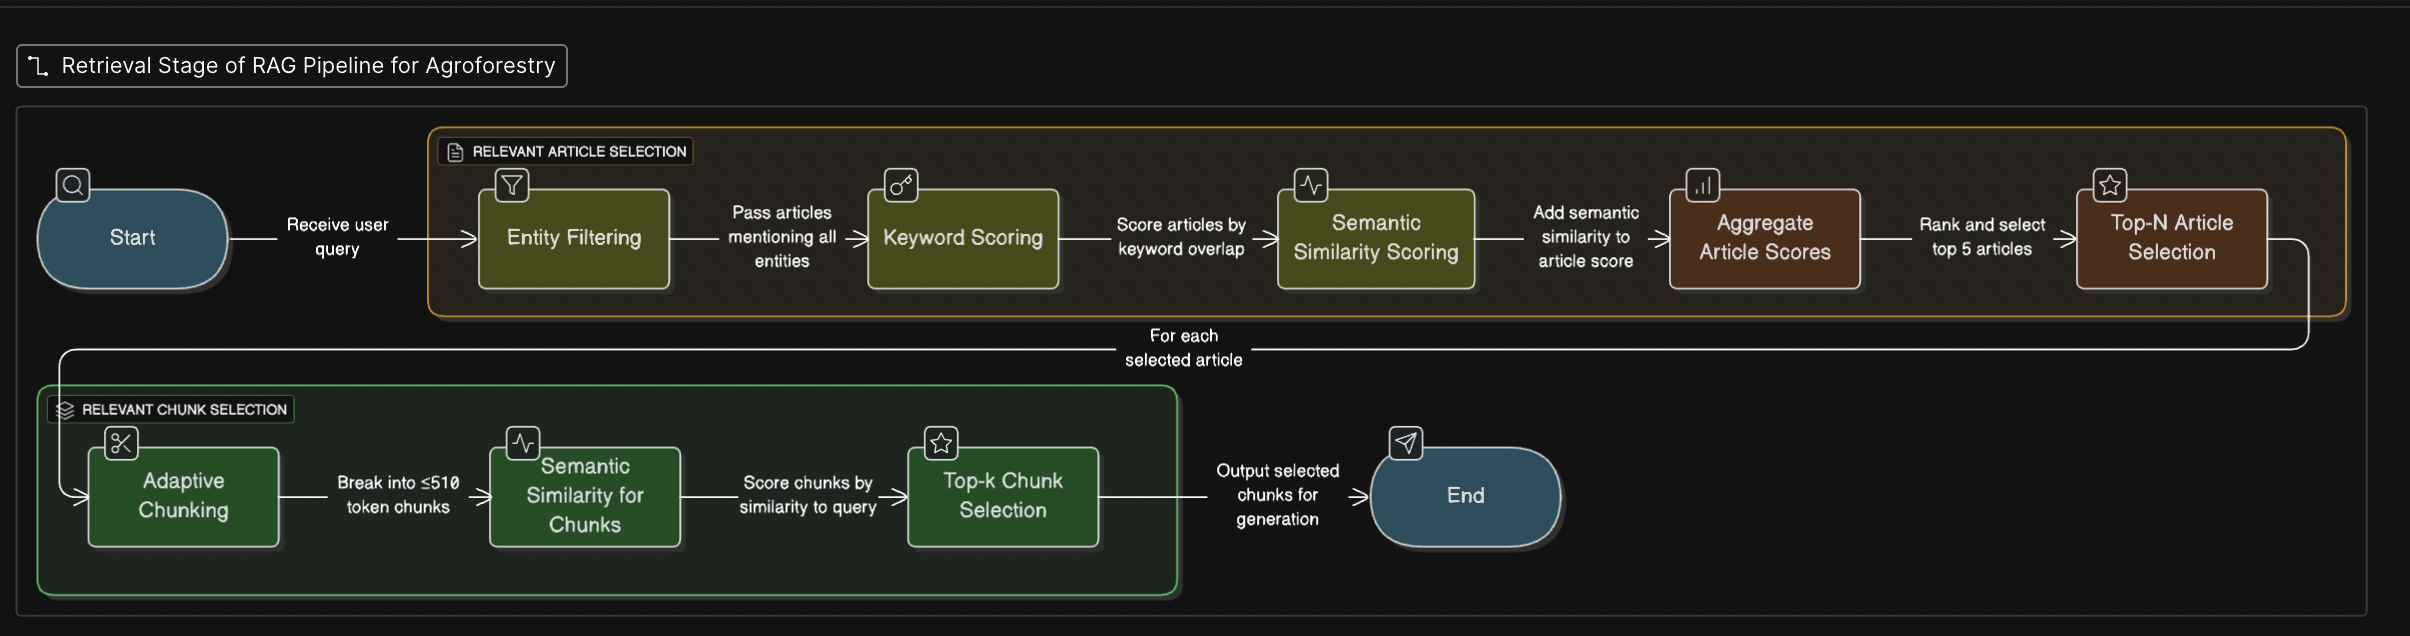

In [ ]:
# Create a Client Connection
# To load/persist db use db location as argument in Client method
client = chromadb.PersistentClient(path="/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/retrieval/chromadb_storage")

# Create/Fetch a collection
collection = client.get_or_create_collection(name="documents")

def get_collection_info():
    """Get basic info about the collection"""
    count = collection.count()
    print(f" Collection contains {count} documents")
    return count

def search_documents(query, n_results):
    """Search for documents"""
    results = collection.query(
        query_texts=[query],
        n_results=n_results
    )
    return results

Running the following code block will check if the database was loaded successfully. If it was loaded successfully, you should see that there are around 2000 documents in the databse

In [ ]:
get_collection_info() #should print number of around 2000

In [ ]:
def cosine(u, v):
    """
    Calculates the cosine similarity between two vectors.

    Cosine similarity measures the cosine of the angle between two non-zero vectors.
    It is a measure of similarity between two vectors of an inner product space that
    measures the cosine of the angle between them. A score of 1 means the vectors
    are identical in direction, 0 means they are orthogonal, and -1 means they are
    diametrically opposed.

    Args:
        u: The first vector (e.g., the embedding of the query).
        v: The second vector (e.g., the embedding of a text chunk).

    Returns:
        The cosine similarity score between the two vectors, a float between -1.0 and 1.0.
    """
    return float(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v) + 1e-9))


def get_relevant_excerpts_dict(query, q_vec, embedding_function, results_dict):
    """
    Identifies and retrieves the most relevant articles
    based on a given query.

    This function first takes in the documents that were found by the vector database,
    and furthur filters to find the top 5 most relevant articles.

    Itt scores each of the retrieved artcles from the vector database
    based on keyword matches and the cosine similarity between the query embedding
    and the article's summary embedding. It returns the top-ranked articles
    as a list of dictionaries.

    Args:
        query (str): The user's question or query.
        q_vec: The embedding vector of the query.
        embedding_function: The function used to generate embeddings (e.g., from HuggingFace).
        results_dict (dict): Dictionary with keys: ids, embeddings, documents, uris,
                           included, data, metadatas, distances

    Returns:
        list[dict]: A list of dictionaries, where each dictionary represents a relevant article
                    and contains its 'label', 'title', and 'text' (the article content).
                    Returns an empty list if no articles are found or relevant.
    """

    # Extract data from results_dict
    metadatas_list = results_dict['metadatas'][0]  # Get the first batch
    documents = results_dict['documents'][0] if 'documents' in results_dict else []

    # Create metadata dictionary and articles data
    metadata = {}
    articles_data = {}

    for i, meta_dict in enumerate(metadatas_list):
        filename = meta_dict['filename']

        # Ensure filename has .json extension for consistency
        if not filename.endswith('.json'):
            filename = filename + '.json'

        # Create the metadata entry with required fields
        metadata[filename] = {
            'key_words': meta_dict.get('key_words', []),
            'summary': meta_dict.get('summary', ''),
            'title': meta_dict.get('title', ''),
            'score': 0  # Initialize score
        }

        # Create article content structure
        article_content = {
            'title': meta_dict.get('title', ''),
            'content': documents[i] if i < len(documents) else '',
            'summary': meta_dict.get('summary', ''),
            'key_words': meta_dict.get('key_words', [])
        }

        # Store as JSON string (to match original function's expectation)
        articles_data[filename] = json.dumps(article_content, indent=2, ensure_ascii=False)

    ## ELIMINATE ARTICLES WITHOUT MAIN DETAILS IN Q
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(query)
    entities = [ent.text for ent in doc.ents if ent.label_ in ["ORG", "PERSON", "GPE", "LOC", "PRODUCT", "NORP", "FAC"]]

    # Only filter if we found entities in the query
    if entities:
        articles_to_remove = []

        # Loop through articles data
        for filename, article_json in articles_data.items():
            try:
                # Check if ALL entities are present in the article string
                entity_missing = False
                for entity in entities:
                    if entity.lower() not in article_json.lower():
                        entity_missing = True
                        break

                # If even one entity is missing, mark for removal
                if entity_missing:
                    articles_to_remove.append(filename)

            except Exception as e:
                print(colored(f"Error processing {filename}: {e}", "red"))
                articles_to_remove.append(filename)

        if (len(articles_to_remove) != len(metadata)):
            # Remove articles that don't contain ALL entities
            for filename in articles_to_remove:
                metadata.pop(filename, None)
                articles_data.pop(filename, None)

        print(colored(f"Filtered from {len(metadata) + len(articles_to_remove)} to {len(metadata)} articles", "green"))

    ## KEY WORDS
    for filename, meta in metadata.items():
        keywords = meta["key_words"]
        for i in range(len(keywords)):
            if (keywords[i] in query):
                meta["score"] += 0.5

    ## SUMMARY COMPARISONS
    for meta in metadata.values():
        if "summary_vec" not in meta:  # cache so can reuse later
            meta["summary_vec"] = embedding_function.embed_query(meta["summary"])

        sim = cosine(q_vec, meta["summary_vec"])  # −1 … 1
        meta["score"] += sim

    ranked = sorted(metadata.items(), key=lambda x: x[1]["score"], reverse=True)
    relevant_articles = []

    for rank, (fname, meta) in enumerate(ranked[:5], start=1):  # top-5
        print(f"{fname:55s}  score={meta['score']:.3f}")
        print(colored(meta["key_words"], "red"))

        # Get article data from memory instead of file
        article_str = articles_data[fname]
        article_dict = json.loads(article_str)

        json_title = fname.replace(".json", "")
        relevant_articles.append({
            "label": f"ARTICLE {rank}",
            "title": json_title,
            "text": article_str
        })

    return relevant_articles


def rerank_context_per_article(articles, query, sentences_per_article, embed_model):
    """
    Reranks sentences within each article based on their relevance to the query and
    returns a combined string of the top sentences from each article.

    This function takes a list of relevant articles, splits each article's text into
    sentences, and then uses an embedding model to calculate the similarity between
    each sentence and the query. It keeps the most relevant sentences per article
    and concatenates them into a single string, preserving the original article
    labeling (e.g., "ARTICLE 1:", "ARTICLE 2:").

    Args:
        articles (list[dict]): A list of dictionaries, where each dictionary represents
                               an article and contains its 'label' and 'text'.
        query (str): The user's question or query.
        sentences_per_article (int): The number of top-ranked sentences to keep from each article.
        embed_model: The SentenceTransformer model used for embedding sentences and the query.

    Returns:
        str: A single string containing the top-ranked sentences from each article,
             formatted with article labels.
    """
    blocks = []

    for art in articles:
        sentences = chunk_document(art["text"])
        reranked = rerank_chunks(sentences, query, embed_model)
        top_k_sents = [s for s, _ in reranked[:sentences_per_article]]

        block = f'{art["label"]}:\n' + "\n".join(top_k_sents)
        blocks.append(block)
    return "\n\n".join(blocks)


def chunk_document(text, max_tokens=400):
    """
    Splits a given text into chunks (sentences) based on sentence boundaries,
    while also considering a maximum token limit per chunk.

    This function uses NLTK's `sent_tokenize` to split the text into sentences
    and then uses a HuggingFace tokenizer to ensure that each resulting chunk
    does not exceed the specified `max_tokens`. If adding a sentence to the
    current chunk would exceed the limit, the current chunk is finalized,
    and a new chunk is started with the current sentence.

    Args:
        text (str): The input text to be chunked.
        max_tokens (int, optional): The maximum number of tokens allowed per chunk.
                                    Defaults to 400.

    Returns:
        list[str]: A list of text chunks (sentences or groups of sentences).
    """
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", token=hugging_face_key)
    chunks, current_chunk = [], []

    for sentence in sent_tokenize(text):
        tentative_chunk = " ".join(current_chunk + [sentence])
        token_ids = tokenizer.encode(tentative_chunk, truncation=False, add_special_tokens=True, max_length=max_tokens)

        if len(token_ids) > max_tokens:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
        else:
            current_chunk.append(sentence)

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


def embed_texts(texts, model):
    """
    Generates embeddings for a list of text strings using a specified embedding model.

    Embeddings are numerical representations of text that capture semantic meaning.
    This function takes a list of text inputs and an embedding model, and returns
    a list of corresponding embedding vectors.

    Args:
        texts (list[str]): A list of text strings to embed.
        model: The embedding model (e.g., a SentenceTransformer model) to use.

    Returns:
        torch.Tensor: A tensor containing the embedding vectors for the input texts.
    """
    embeddings = model.encode(texts, convert_to_tensor=True)
    return embeddings


def rerank_chunks(chunks, query, embed_model):
    """
    Ranks a list of text chunks based on their cosine similarity to a given query.

    This function calculates the embedding for the query and each chunk, then
    computes the cosine similarity between the query embedding and each chunk
    embedding. It returns a list of chunks paired with their similarity scores,
    sorted in descending order of similarity (most relevant first).

    Args:
        chunks (list[str]): A list of text chunks to be ranked.
        query (str): The user's question or query.
        embed_model: The SentenceTransformer model used for embedding.

    Returns:
        list[tuple[str, float]]: A list of tuples, where each tuple contains a
                                 chunk (str) and its cosine similarity score (float)
                                 with the query, sorted by score in descending order.
    """
    query_embedding = embed_model.encode(query)

    chunk_embeddings = embed_model.encode(chunks)

    similarities = cosine_similarity(
        [query_embedding],
        chunk_embeddings
    )[0]

    scored_chunks = list(zip(chunks, similarities))
    scored_chunks.sort(key=lambda x: x[1], reverse=True)

    return scored_chunks


def rerank_context(excerpts, user_question, relevant_count, embed_model):
    """
    Reranks sentences from provided excerpts based on relevance to the user question
    and returns a specified number of the most relevant sentences as a single string.

    This function first combines the text from multiple excerpts (if provided as a list)
    into a single string. It then splits this text into sentences (chunks), calculates
    their relevance to the user question using embeddings, and returns the top
    `relevant_count` sentences concatenated into a single string.

    Args:
        excerpts (list[dict] or str): A list of dictionaries representing articles
                                     (each with a 'text' key) or a single string
                                     containing the combined text of excerpts.
        user_question (str): The user's question for reranking.
        relevant_count (int): The number of most relevant sentences to return.
        embed_model: The SentenceTransformer model used for embedding.

    Returns:
        str: A string containing the `relevant_count` most relevant sentences
             from the excerpts.
    """
    if isinstance(excerpts, list):
        excerpts = "\n".join(excerpts)  # collapse list → one big string

    chunks = chunk_document(excerpts)  # now safe: string → sent_tokenize
    reranked = rerank_chunks(chunks, user_question, embed_model)
    context = "\n".join(chunk for chunk, _ in reranked[:relevant_count])

    return context



def flatten_article_text(article_json):
    """
    Extracts all string content from a potentially nested JSON structure,
    concatenating it into a single string.

    This function recursively traverses through the JSON object (dictionaries and lists)
    and collects all string values it encounters. This is useful for extracting
    the raw text content from a structured article JSON.

    Args:
        article_json (dict or list): The JSON object representing an article.

    Returns:
        str: A single string containing all the extracted text content, joined by newlines.
    """
    text_blocks = []

    def recursive_extract(obj):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    recursive_extract(v)
                elif isinstance(v, str):
                    text_blocks.append(v)
        elif isinstance(obj, list):
            for item in obj:
                recursive_extract(item)

    recursive_extract(article_json)
    return "\n".join(text_blocks)


def get_tables(excerpts, context_chars: int = 250):
    """
    Extracts markdown-style tables from the text content of article excerpts
    and includes a specified amount of leading context for each table.

    This function searches for patterns that resemble markdown tables within
    the text of each excerpt. For each identified table, it extracts the table
    content along with `context_chars` characters preceding the table.
    It then saves these extracted table chunks to a file and returns them as
    a single string.

    Args:
        excerpts (list[dict]): A list of dictionaries, where each item looks
                               like {"label": "...", "text": "<raw-json-string>"}.
        context_chars (int, optional): The number of characters of leading
                                       context to preserve before each table.
                                       Defaults to 250.

    Returns:
        str: A single string containing all extracted table chunks with their
             leading context, separated by double newlines.
    """
    print(colored("\nExtracting tables with context …\n", "green"))

    # ≥2 consecutive lines that both start & end with a vertical bar
    tbl_pat = re.compile(r'(?:^\s*\|.*?\|\s*(?:\r?\n|\r)){2,}',
                         re.MULTILINE)

    chunks = []

    for art in excerpts:
        label = art.get("title", "No Label")

        # ---------- 1. decode the JSON held in "text"
        try:
            article = json.loads(art["text"])
            sections = article.get("sections", [])
        except Exception as e:
            print(f"⚠️  {label}: JSON decode failed – {e}")
            continue

        # ---------- 2. flatten all section content
        text = "\n".join(
            ln for sec in sections for ln in sec.get("content", [])
        )

        # ---------- 3. find every table *with positions*
        for m in tbl_pat.finditer(text):
            start, end = m.span()

            # 4. grab `context_chars` before the table
            ctx_start = max(0, start - context_chars)
            snippet = text[ctx_start:end].strip()

            # prepend ellipsis if we chopped off the very beginning
            if ctx_start > 0:
                snippet = "… " + snippet

            chunks.append(f"{label}:\n{snippet}")

    # ---------- 5. write & return
    print(colored(f"Extracted {len(chunks)} chunk(s).\n", "green"))

    with open("table_chunks.txt", "w", encoding="utf-8") as fh:
        fh.write("\n\n".join(chunks))

    print(colored("Saved → table_chunks.txt", "green"))
    return "\n\n".join(chunks)


def get_numerical_sentences_from_articles(client, model, excerpts, user_question, sentences_per_article, embedding_function):
    """
    Extracts and returns sentences from article excerpts that contain numerical information.

    This function iterates through the sentences of each article excerpt and uses
    regular expressions to identify sentences that likely contain numerical data.
    It attempts to exclude sentences that appear to be part of tables or citations,
    focusing on sentences with narrative indicators that incorporate numbers.
    It returns a filtered list of sentences containing numerical information.

    Args:
        client: The LLM client object (not directly used in this function, but
                included for potential future use or consistency).
        model (str): The name of the LLM model (not directly used in this function).
        excerpts (list[dict]): A list of dictionaries, where each item represents
                               an article excerpt and contains its 'text'.
        user_question (str): The user's question (not directly used for extraction,
                             but relevant for the overall RAG process).
        sentences_per_article (int): The target number of sentences per article
                                     (not strictly enforced in this function's filtering).
        embedding_function: The function used for embedding (not directly used
                            for filtering, but relevant for downstream steps).

    Returns:
        list[str]: A list of sentences extracted from the excerpts that contain
                   numerical information and are not likely part of tables or citations.
    """
    embedded_question = embedding_function.embed_query(user_question)
    numerical_sentences = []

    # table_regex = r'\b\d+(?:\.\d+)?\s+\d+(?:\.\d+)?\s+\d+(?:\.\d+)?\b'
    nontable_regex = r'\b(?:is|are|was|were|has|have|had|shows?|indicates?|suggests?|demonstrates?|reveals?|found|observed|measured|recorded|increased|decreased|compared|resulted|concluded)\b'
    numerical_regex = [
        r'\b\d+(?:\.\d+)?%',  # Percentages:
        r'\b\d+(?:,\d{3})*(?:\.\d+)?\s*(?:million|billion|trillion|thousand|k|M|B|T)\b',  # Large numbers
        r'\b\d+(?:,\d{3})*(?:\.\d+)?\s*(?:times|fold|×|x)\b',  # Multipliers
        r'\b\d+(?:\.\d+)?\s*(?:degrees?|°[CF]?)\b',  # Temperature/angles
        r'\b\d+(?:\.\d+)?\s*(?:kg|g|mg|lb|tons?|tonnes?)\b',  # Weight
        r'\b\d+(?:\.\d+)?\s*(?:m|km|cm|mm|ft|miles?|inches?)\b',  # Distance
        r'\b\d+(?:\.\d+)?\s*(?:years?|months?|days?|hours?|minutes?|seconds?)\b',  # Time
        r'\b\d+(?:\.\d+)?\s*(?:USD|EUR|GBP|\$|€|£)\b',  # Currency
        r'\$\d+(?:,\d{3})*(?:\.\d+)?(?:\s*(?:million|billion|trillion|thousand|k|M|B|T))?\b',  # Dollar amounts
        r'\b(?:increased|decreased|rose|fell|grew|declined|improved|reduced)\s+(?:by\s+)?\d+(?:\.\d+)?%',  # Change percentages
        r'\b\d+(?:\.\d+)?\s*(?:to|and|\-)\s*\d+(?:\.\d+)?(?:%|\s*(?:million|billion|trillion|thousand|k|M|B|T))?\b',  # Ranges
        r'\b(?:approximately|about|around|roughly|nearly|over|under|more than|less than|at least|up to)\s+\d+(?:\.\d+)?(?:%|\s*(?:million|billion|trillion|thousand|k|M|B|T))?\b',  # Approximations
        r'\b\d+(?:\.\d+)?\s*(?:L|ml|gallons?|liters?|litres?)\b',  # Volume
        r'\b\d+(?:\.\d+)?\s*(?:Hz|kHz|MHz|GHz)\b',  # Frequency
        r'\b\d+(?:\.\d+)?\s*(?:W|kW|MW|GW|watts?)\b',  # Power
        r'\bp\s*[<>=]\s*0\.\d+\b',  # P-values
        r'\b\d+(?:\.\d+)?\s*(?:standard deviations?|SD|σ)\b',  # Standard deviations
        r'\br\s*=\s*0\.\d+\b',  # Correlation coefficients
    ]
    non_numercial_regex = [
        # Table patterns
        r'\btable\s+\d+\b',  # Table titles like "Table 1"
        r'\bfigure\s+\d+\b',  # Figure references
        r'\bappendix\s+[a-z]\b',  # Appendix references
        r'^\s*\|.*\|\s*$',  # Table rows with pipes

        # Reference patterns
        r'https?://doi\.org/[^\s,]+',  # DOI links
        r'https?://dx\.doi\.org/[^\s,]+',  # Alternative DOI format
        r'doi:\s*10\.\d+/[^\s,]+',  # DOI without http
        r'https?://[^\s,]+',  # General URLs
        r'www\.[^\s,]+',  # www URLs without http

        # Citation patterns
        r'\b[A-Z][a-z]+,\s+[A-Z]\.\s*[A-Z]?\.',  # "Smith, J. R."
        r'\bet\s+al\.',  # "et al."
        r'\b\(\d{4}[a-z]?\)',  # Years like (2014), (2014a)
        r'^\s*\[\d+\]',  # Reference numbers [1], [23]
        r'^\s*\d+\.',  # Numbered references like "1. Smith..."

        # Journal/publication patterns
        r'\b\d{4}\.\d{4,5}\b',  # ISSN numbers
        r'\bISBN[-\s]?\d+',  # ISBN numbers
        r'\bvol\.\s*\d+',  # Volume numbers
        r'\bpp\.\s*\d+',  # Page numbers
    ]
    for i in range(len(excerpts)):
        article = excerpts[i]["text"]

        sentences = sent_tokenize(article)  # breaks down by sentence

        for sentence in sentences:
            # Check if sentence matches any table pattern
            is_table = any(re.search(regex, sentence, re.IGNORECASE | re.MULTILINE) for regex in non_numercial_regex)

            # Check if sentence has narrative indicators
            has_narrative = re.search(nontable_regex, sentence, re.IGNORECASE)

            # Process if: (not table content) OR (has strong narrative indicators)
            # if not is_table or has_narrative:
            if not is_table:
                for regex in numerical_regex:
                    if re.search(regex, sentence):
                        numerical_sentences.append(sentence)
                        break
    total_sentences = len(numerical_sentences)
    sentences_to_keep = int(total_sentences * 0.3)  # only around the front 30% is actual sentences, rest is random table or citation information
    numerical_sentences = numerical_sentences[:sentences_to_keep]

    with open("final_numerical_sentences.txt", "w", encoding="utf-8") as fh:
        fh.write("\n\n".join(numerical_sentences))

    return numerical_sentences


def get_numerical_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article, embedding_function):
    """
    Extracts and returns numerical chunks from articles, prioritizing tables and then
    including a selection of numerical sentences.

    This function first calls `get_tables` to extract any markdown-style tables
    from the excerpts. It then calls `get_numerical_sentences_from_articles` to
    get sentences containing numerical data. The extracted tables and numerical
    sentences are combined and returned as a single string.

    Args:
        client: The LLM client object (not directly used in this function).
        model (str): The name of the LLM model (not directly used in this function).
        excerpts (list[dict]): A list of dictionaries, where each item represents
                               an article excerpt and contains its 'text'.
        user_question (str): The user's question.
        sentences_per_article (int): The target number of sentences per article
                                     (passed to `get_numerical_sentences_from_articles`).
        embedding_function: The function used for embedding (passed to
                            `get_numerical_sentences_from_articles`).

    Returns:
        str: A single string containing extracted table content and numerical sentences.
    """
    tables = get_tables(excerpts)
    sentences = get_numerical_sentences_from_articles(client, model, excerpts, user_question, sentences_per_article=6, embedding_function=embedding_function)
    with open("table_chunks.txt", "w", encoding="utf-8") as fh:
        fh.write("\n\n".join(sentences))
    chunks = tables + "\n\n".join(sentences)
    print(colored(f"Extracted {len(chunks)} chunk(s).\n", "green"))
    # return tables
    return chunks


def get_text_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article, embedding_function):
    """
    Generates text chunks from articles by prompting an LLM to extract the most
    relevant sentences based on the user question.

    This function iterates through each article excerpt and constructs a prompt
    for the LLM. The prompt asks the LLM to identify and return a specified number
    of sentences from the article that are most relevant to the user question.
    It then calls the LLM client to get the response (the extracted sentences)
    and collects these responses for each article.

    Args:
        client: The LLM client object (e.g., an Ollama client).
        model (str): The name of the LLM model to use for prompting.
        excerpts (list[dict]): A list of dictionaries, where each item represents
                               an article excerpt and contains its 'text'.
        user_question (str): The user's question used to guide the LLM's extraction.
        sentences_per_article (int): The number of relevant sentences the LLM
                                     should extract from each article.
        embedding_function: The function used for embedding (not directly used
                            in this function).

    Returns:
        list[str]: A list of strings, where each string contains the sentences
                   extracted by the LLM from a corresponding article excerpt.
    """
    embedded_question = embedding_function.embed_query(user_question)
    context = []
    sentences_with_numbers = []

    for i in range(len(excerpts)):
        article = excerpts[i]["text"]
        sentences = article.split(".")

        prompt = f"""You are an expert assistant for interpreting scientific research on agroforestry and carbon sequestration. Check whether the following article contains information relevant to the question: {user_question}.
        If it does, return the first {sentences_per_article} sentences that are relevant to the question. If it does not, return "Answer not found in provided excerpts". Assume that the articles are talking about the same location as the question. ONLY return the sentences, no extra text, no explanation, no interpretation, no commentary."
        {article}
        """
        # cut references from prompt
        if "References" in prompt:
            prompt = prompt.split("References")[0]

        # cut to first 6000 characters
        if len(prompt) > 6000:
            print(colored(f"Prompt too long ({len(prompt)} characters), truncating to 6000 characters.", "red"))
            prompt = prompt[:6000]

        context.append(
            ollama_chat(
                client, model,
                [{"role": "user", "content": prompt}]
            )
        )

    return context


def get_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article, embedding_function, type_question):
    """
    Selects and calls the appropriate chunk extraction function based on the
    type of question (numerical or text) and returns the extracted chunks.

    This function acts as a router, deciding whether to use `get_numerical_chunks_from_articles`
    or `get_text_chunks_from_articles` based on the `type_question` parameter.
    It also includes a fallback to text-based extraction if an invalid type
    is provided.

    Args:
        client: The LLM client object.
        model (str): The name of the LLM model.
        excerpts (list[dict]): A list of dictionaries representing article excerpts.
        user_question (str): The user's question.
        sentences_per_article (int): The number of sentences to consider per article.
        embedding_function: The function used for embedding.
        type_question (str): The type of question, either "num" for numerical
                             or "text" for text-based extraction.

    Returns:
        str or list[str]: The extracted chunks, which can be a single string
                          (for numerical) or a list of strings (for text),
                          depending on the chosen extraction method.
    """
    if type_question == "num":
        print(colored("Numerical question detected, using numerical response generation.", "green"))
        tables = get_tables(excerpts)
        return get_numerical_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article=sentences_per_article, embedding_function=embedding_function)
    elif type_question == "text":
        print(colored("Text question detected, using text response generation.", "green"))
        return get_text_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article, embedding_function)
    else:
        print(colored("Invalid type_question, defaulting to text response generation.", "red"))
        type_question = "text"
        return get_text_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article, embedding_function)






# **Generation Stage**

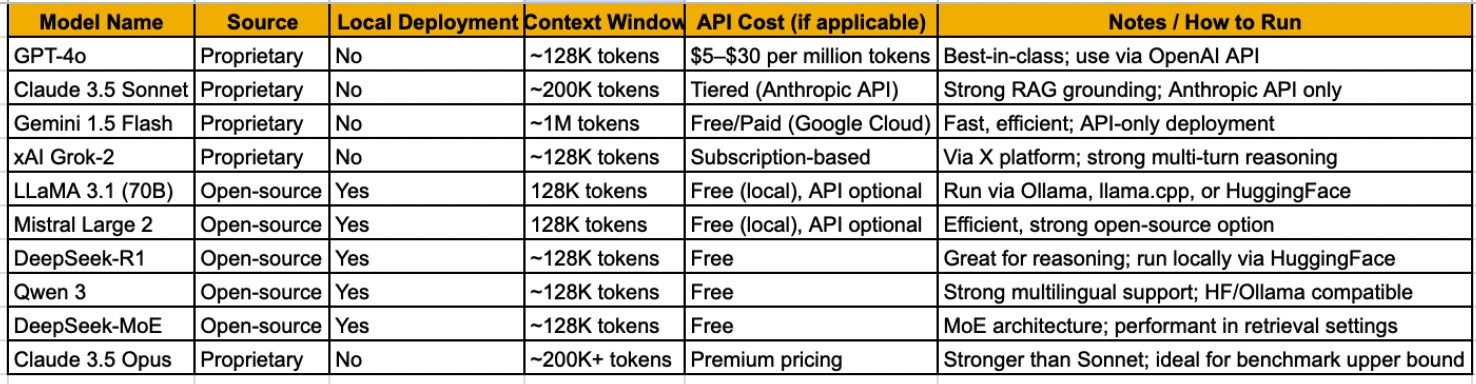

In [ ]:
def ollama_chat(client, model, messages):
    """
    A wrapper function to interact with the Ollama chat model.

    This function sends a list of messages (representing the conversation history
    and the current prompt) to the specified Ollama model using the provided
    client. It then extracts and returns the content of the model's response.

    Args:
        client: The Ollama client object.
        model (str): The name of the Ollama model to use for the chat completion.
        messages (list[dict]): A list of message dictionaries, typically in the
                               format [{"role": "system", "content": "..."},
                                       {"role": "user", "content": "..."},
                                       {"role": "assistant", "content": "..."}, ...].

    Returns:
        str: The content of the message generated by the Ollama model.
    """
    resp = client.chat(model=model, messages=messages)
    return resp["message"]["content"]

def generate_response(client, model, user_question, relevant_excerpts, benchmarking):
    """
    Generates a grounded response to the user question using an LLM (Groq in this case)
    and provided relevant text excerpts.

    This function constructs a prompt for the LLM, including a system prompt
    (loaded from a file) and the user's question along with the relevant excerpts.
    It then sends this prompt to the LLM client and returns the generated response.
    It also saves the user question and relevant excerpts to a file for debugging.

    Args:
        client: The LLM client object (e.g., an Ollama client).
        model (str): The name of the LLM model to use for generation.
        user_question (str): The user's question.
        relevant_excerpts (str): A string containing the relevant text excerpts
                                 to ground the response.
        benchmarking (bool): A flag indicating whether benchmarking is enabled (not used
                             in the function's core logic but included in the signature).

    Returns:
        str: The generated response from the LLM.
    """
    #with open("/content/drive/MyDrive/Nature Conservancy/RAG Team/generation/prompt.txt", "r") as f:
    with open("/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/generation/prompt.txt", "r") as f:
        system_prompt = f.read()

    messages = []
    messages.append({"role": "system", "content": system_prompt})

    messages.append({"role": "system", "content": "Be **very** concise, don't have to explain each thought process"})
    '''
    # open the questions folder and list all the files
    questions_dir = os.path.join(os.path.dirname(__file__), "/content/drive/MyDrive/Nature Conservancy/RAG Team/generation/questions")
    question_files = os.listdir(questions_dir)
    answer_dir = os.path.join(os.path.dirname(__file__), "/content/drive/MyDrive/Nature Conservancy/RAG Team/generation/answers")
    answer_files = os.listdir(answer_dir)
    question_files = [os.path.join(questions_dir, f) for f in question_files if f.endswith('.txt')]
    answer_files = [os.path.join(answer_dir, f) for f in answer_files if f.endswith('.txt')]
    for i in range(len(question_files)):
        # open the file
        with open(question_files[i]) as f:
            messages.append({"role": "user", "content": f.read()})
        with open(answer_files[i]) as f:
            messages.append({"role": "assistant", "content": f.read()})

'''
    messages.append({"role": "user", "content": f"User Question: {user_question}\n\nRelevant Excerpts:\n\n{relevant_excerpts}"})

    with open("user_question.txt", "w") as f:
        f.write("User Question:" + user_question + "\n\n" + "Relevant Excerpts:" + "\n\n" + relevant_excerpts)

    return ollama_chat(client, model, messages)


## Running the model

This section contains the main execution flow of the Agroforestry RAG system. It orchestrates the steps involved in processing a user's question and generating a grounded answer. The key steps performed in this section include:

1.  **Initialization:** Setting up the Ollama client for interacting with the LLM and initializing the embedding models (HuggingFace and SentenceTransformer) used for creating text embeddings.
2.  **Metadata Loading:** Loading the metadata about the available articles, which includes information like keywords and summaries used for initial retrieval.
3.  **User Input:** Prompting the user to enter their question and specify whether a numerical or text-based answer is expected.
4.  **Question Embedding:** Converting the user's question into a numerical embedding vector using the embedding function. This vector is used to find relevant articles and sentences.
5.  **Article Retrieval:** Using the question embedding and metadata to identify and retrieve the most relevant articles from the collection of JSON documents. This step filters down the potential sources of information.
6.  **Chunk Extraction:** Processing the retrieved articles to extract the most relevant text chunks based on the question type (numerical or text). This may involve extracting tables, numerical sentences, or using the LLM to identify key sentences.
7.  **Response Generation:** Providing the extracted relevant chunks and the user's question to the LLM to generate a coherent and grounded answer. The LLM synthesizes the information from the chunks to formulate the response.
8.  **Output and Benchmarking:** Displaying the generated answer to the user and providing a breakdown of the time taken for each stage of the process.

The code in this section runs in a loop, allowing the user to ask multiple questions without restarting the entire process.

In [ ]:
import time
from datetime import datetime

def main():
    start_time = time.time()
    print(f"🕐 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    model = llm_model_name

    print("🔧 Initializing clients and models...")
    init_start = time.time()

    client = ollama.Client(host="http://localhost:11434")
    embedding_function=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    embed_model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1")

    init_time = time.time() - init_start
    print(f"⏱️  Initialization took: {init_time:.2f} seconds")

    print("\n🌿 Agroforestry RAG System (Powered by ChromaDB + Deepseek)")
    print("Ask a question related to carbon stocks, sequestration, soil data, or agroforestry studies.\n")

    while True:
        # Load metadata
        metadata_start = time.time()
        with open("/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/retrieval/metadata.json", "r") as f:
            metadata = json.load(f)
        for filename, meta in metadata.items():
            meta["score"] = 0
        metadata_time = time.time() - metadata_start
        print(f"📄 Metadata loading took: {metadata_time:.3f} seconds")

        # type_question = input(colored("Type 'num' if your question needs a numerical answer or 'text' if it needs a text answer: ", "yellow")).strip().lower()
        type_question = "num"
        user_question = input(colored("🔎 Your question: ", "yellow")).strip()

        if not user_question:
            continue

        question_start = time.time()

        # Embed the question
        embed_start = time.time()
        q_vec = embedding_function.embed_query(user_question)
        embed_time = time.time() - embed_start
        print(f"🔤 Question embedding took: {embed_time:.3f} seconds")

        path_to_articles = "/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/completed JSONs"

        # Get the correct articles
        retrieval_start = time.time()
        chroma_excerpts = search_documents(user_question, n_results=30)
        excerpts = get_relevant_excerpts_dict(user_question, q_vec, embedding_function, chroma_excerpts)
        retrieval_time = time.time() - retrieval_start
        print(f"📚 Article retrieval took: {retrieval_time:.3f} seconds")

        # Get the right chunks from the articles
        chunks_start = time.time()
        context = get_chunks_from_articles(client, model, excerpts, user_question, sentences_per_article=6, embedding_function=embedding_function, type_question=type_question)
        chunks_time = time.time() - chunks_start
        print(f"🧩 Chunk extraction took: {chunks_time:.3f} seconds")

        # Generate response
        response_start = time.time()
        response = generate_response(client, model, user_question, context, benchmarking=False)
        response_time = time.time() - response_start
        print(f"🤖 Response generation took: {response_time:.3f} seconds")

        total_question_time = time.time() - question_start
        print(f"⏰ Total processing time for this question: {total_question_time:.3f} seconds")

        print(colored("\n Answer:\n" + response + "\n", "magenta"))

        # Performance breakdown
        print(colored("📊 Performance Breakdown:", "cyan"))
        print(colored(f"  • Question embedding: {embed_time:.3f}s ({embed_time/total_question_time*100:.1f}%)", "cyan"))
        print(colored(f"  • Article retrieval: {retrieval_time:.3f}s ({retrieval_time/total_question_time*100:.1f}%)", "cyan"))
        print(colored(f"  • Chunk extraction: {chunks_time:.3f}s ({chunks_time/total_question_time*100:.1f}%)", "cyan"))
        print(colored(f"  • Response generation: {response_time:.3f}s ({response_time/total_question_time*100:.1f}%)", "cyan"))
        print(colored(f"  • Total: {total_question_time:.3f}s\n", "cyan"))

#Testing question: What is the aboveground_carbon of planting shaded agroforests in Plateau region?



In [ ]:
if __name__ == "__main__":
    main()

🕐 Started at: 2025-07-09 12:41:09
🔧 Initializing clients and models...
⏱️  Initialization took: 2.41 seconds

🌿 Agroforestry RAG System (Powered by ChromaDB + Deepseek)
Ask a question related to carbon stocks, sequestration, soil data, or agroforestry studies.

📄 Metadata loading took: 0.008 seconds
🔤 Question embedding took: 0.011 seconds
Filtered from 60 to 30 articles
cleaned_da Rocha 2018 Distribution of.json               score=44.457
["soil", "agroforestry", "forestry", "pasture", "aggregates", "organic", "inorganic", "this", "higher", "availability"]
cleaned_Zeng2014_Article_ChangeOfSoilOrganicCarbonAfter.json  score=39.428
["soil", "soc", "carbon", "korshinskii", "tomentosa", "change", "climate", "density", "program", "revegetation"]
cleaned_Singh 2018 soil organic carbon agroforestry systems elevation gradient Himalaya.json  score=39.005
["carbon", "soil", "agroforestry", "organic", "systems", "elevation", "density", "mean", "higher", "biomass"]
cleaned_Gomes de Abreu 2020 Var

Note for above code: If the output is something like "Server disconnected without sending a response", this means that the Ollama server we set up at the beginning of this notebook must have disconnected. If this happens, you should go back up to the cell that had "%xterm", and rerun that cell per the original instructions.

Once you do that, rerun the cell above:


```
if __name__ == "__main__":
    main()
```



Benchmarking

In [ ]:
# Load questions
with open("/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/benchmark/benchmarking.json", "r") as f:
    qa_data = json.load(f)

all_questions = list(qa_data .items())

sampled_questions = random.sample(all_questions, max(1, len(all_questions) // 200))



In [ ]:
def similarity_score(model_response, answer):
    """
    Calculates a similarity score between the model's response and the actual answer.

    This function prompts an LLM to compare the model's generated response with
    a provided correct answer and return a similarity score between 0.00 and 1.00.
    It handles cases where the model response indicates that the answer was not
    found in the provided excerpts.

    Args:
        model_response (str): The response generated by the RAG model.
        answer (str): The correct or benchmark answer.

    Returns:
        float: A similarity score between 0.00 and 1.00, where 1.00 indicates high
               similarity and 0.00 indicates no similarity or that the answer
               was not found.
    """
    if model_response == "Answer not found in provided excerpts.":
        return 0
    messages = [
            {
                "role": "system", "content" : f"""Given this value: {model_response} and this value: {answer}. Give
                a score to how similar they are on a range of 0.00 - 1.00. If these two values are in different units, convert to the same unit first
                then compare. ONLY output the similarity score and no other text. If the model response was Answer not found in provided excerpts. return 0"""
            }
        ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # Generate output from model
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=512
    )

    # Decode output
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    similarity = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    try:
        similarity = float(similarity)
        return similarity
    except:
        print("not successful")
        return 0


def benchmark():

    print("\n🌿 Agroforestry RAG System (Powered by ChromaDB + Deepseek)")
    print("Ask a question related to carbon stocks, sequestration, soil data, or agroforestry studies.\n")

    results = []
    type_question = "num"
    cnt = 1

    for question, answer_parts in sampled_questions:
      print(cnt)
      torch.cuda.empty_cache()
      numeric_value, unit = answer_parts[1], answer_parts[2]
      true_answer = f"{numeric_value} {unit}"

      # embed question
      q_vec = embedding_function.embed_query(question)
      with open("/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/retrieval/metadata.json", "r") as f:
          metadata = json.load(f)
      for meta in metadata.values():
          meta["score"] = 0

      # getting context + generation
      path_to_articles = "/content/drive/MyDrive/Nature Conservancy/RAG Team/RAG Materials/completed JSONs"
      excerpts = get_relevant_excerpts(question, q_vec, embedding_function, metadata, path_to_articles, nlp)

      context = get_chunks_from_articles(excerpts, question, sentences_per_article=6, embedding_function=embedding_function, type_question=type_question)

      # Generate response
      response = generate_response(question, context, benchmarking=False)

      # Check similarity
      similarity = similarity_score(response, true_answer)

      results.append({
          "question": question,
          "true_answer": true_answer,
          "model_answer": str(response),
          "similarity": float(similarity)
      })

      print(colored(f"\nQ: {question}", "yellow"))
      print(colored(f" Answer: {true_answer}", "green"))
      print(colored(f"Model: {response}", "cyan"))
      print(colored(f"Similarity: {similarity:.3f}", "magenta"))
      cnt += 1


    with open("benchmark_results.json", "w") as f:
      json.dump(results, f, indent=2)

    avg_score = np.mean([r["similarity"] for r in results])
    print(colored(f"\nAverage Embedding Similarity: {avg_score:.3f}", "green"))




In [ ]:
benchmark()

## Conclusion

This notebook demonstrates a functional Retrieval-Augmented Generation (RAG) system for answering questions about agroforestry using a knowledge base of JSON articles. By combining information retrieval techniques with the generative capabilities of a large language model, the system aims to provide more accurate and contextually relevant answers than an LLM alone.

The system's modular design, with separate functions for different tasks like embedding, retrieval, chunking, and generation, allows for flexibility and potential future improvements. The benchmarking information provided helps to understand the performance characteristics of each stage of the RAG pipeline.

Potential areas for future work include:

*   **Improving Information Retrieval:** Exploring more advanced indexing and retrieval techniques (e.g., using vector databases) to handle larger knowledge bases and improve retrieval accuracy.
*   **Enhancing Text Processing:** Investigating more sophisticated chunking and reranking strategies to ensure the most relevant information is extracted and presented to the LLM.
*   **Optimizing LLM Interaction:** Experimenting with different prompting techniques, LLM models, and parameters to improve the quality and conciseness of the generated responses.
*   **Handling Diverse Data Formats:** Extending the system to handle information from various data formats beyond JSON, such as PDFs, spreadsheets, or databases.
*   **User Interface:** Developing a more user-friendly interface for interacting with the RAG system.

Overall, this notebook provides a solid foundation for building a RAG system for domain-specific question answering, highlighting the power of combining retrieval and generation for improved accuracy and trustworthiness.

## Agroforestry RAG System

This notebook implements a Retrieval-Augmented Generation (RAG) system designed to answer questions about agroforestry, focusing on topics like carbon stocks, sequestration, and soil data. The system leverages a combination of techniques including:

1. **Information Retrieval:** Identifying relevant articles from a collection of JSON documents based on the user's query.
2. **Text Processing:** Chunking and reranking text excerpts from the retrieved articles to extract the most relevant information.
3. **Language Model (LLM) Generation:** Using a large language model (LLM) to synthesize the extracted information and generate a coherent answer to the user's question.

The goal is to provide accurate and contextually grounded answers by retrieving information from a specific knowledge base (the provided JSON articles) rather than relying solely on the LLM's pre-existing training data. This approach helps to reduce the risk of the LLM "hallucinating" or generating incorrect information.


The notebook is structured into several sections:

* **Set up and Installation:** Installs necessary libraries and sets up the environment.
* **Utilities:** Defines helper functions for tasks like calculating cosine similarity, retrieving relevant articles, chunking text, embedding text, reranking text, and generating responses.
* **Running the model:** Contains the main execution logic for the RAG system, including loading data, processing the query, retrieving and processing articles, and generating the final answer.
* **Benchmarking:** (If applicable) Provides a section for evaluating the performance of the RAG system.

Each section includes code cells and markdown descriptions to explain the steps involved.